In [1]:
import argparse
import os
import time
import pickle
import pdb

import numpy as np
import sys
import torch
from torch.autograd import Variable
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt


sys.path.append('..')

from lib.pooling import GeM
from lib.normalization import L2N
from lib.TYY_DAME_model import *



In [2]:
def whitenapply(X, m, P, dimensions=None):
    
    if not dimensions:
        dimensions = P.shape[0]

    X = np.dot(P[:dimensions, :], X-m)
    X = X / (np.linalg.norm(X, ord=2, axis=0, keepdims=True) + 1e-6)

    return X



class DAME_var(nn.Module):
    def __init__(self, ch, delta_scale, ini_p, alpha):
        super(DAME_var, self).__init__()

        self.ch = ch
        self.eps = 1e-6
        self.delta_scale = delta_scale
        self.ini_p = ini_p
        self.fc = nn.Linear(self.ch,1)
        self.fc.weight.data.zero_()
        self.fc.bias.data.copy_((self.ini_p-1)/self.delta_scale*torch.ones(1))
        self.sigmoid = nn.Sigmoid()
        self.alpha = alpha

    def forward(self, x):

        feat_x = x.view(-1,x.size(1),x.size(2)*x.size(3)).var(dim=-1)

        feat_x = feat_x.view(-1,self.ch)
        feat_x = self.fc(feat_x)
        p_delta = self.sigmoid(self.alpha*feat_x)*self.delta_scale

        dyn_p = 1 + p_delta

        dyn_p_un = dyn_p.unsqueeze(-1).unsqueeze(-1)
        # dyn_p_un = dyn_p_un.repeat((1,x.size(1),x.size(2),x.size(3)))

        x = torch.pow(x.clamp(min=self.eps),dyn_p_un)
        x = F.avg_pool2d(x, (x.size(-2), x.size(-1)))
        x = x.squeeze(-1).squeeze(-1)
        
        desc = torch.pow(x,1./dyn_p)

        return desc, dyn_p



class TYY_DAME_var_Res101(nn.Module):
    
    def __init__(self, features, lwhiten, pool, whiten, meta, delta_scale=4, alpha=1):
        super(TYY_DAME_var_Res101, self).__init__()

        self.features = nn.Sequential(*features)
        #features are the seperated modules of the models
        #Here recombining them into a whole model
        self.lwhiten = lwhiten
        self.pool = pool
        self.whiten = whiten
        self.norm = L2N()
        self.meta = meta
        self.DAME3 = DAME_var(ch=2048,delta_scale=delta_scale,ini_p=3,alpha=alpha)

    def forward(self, x):
        
        with torch.no_grad():
            x = self.features(x)

        x, dyn_p = self.DAME3(x)

        o = self.norm(x)
        # permute so that it is Dx1 column vector per image (DxN if many images)
        return o.permute(1,0)


    def __repr__(self):
        tmpstr = super(TYY_DAME_var_Res101, self).__repr__()[:-1]
        tmpstr += self.meta_repr()
        tmpstr = tmpstr + ')'
        return tmpstr

    def meta_repr(self):
        tmpstr = '  (' + 'meta' + '): dict( \n' # + self.meta.__repr__() + '\n'
        tmpstr += '     architecture: {}\n'.format(self.meta['architecture'])
        tmpstr += '     local_whitening: {}\n'.format(self.meta['local_whitening'])
        tmpstr += '     pooling: {}\n'.format(self.meta['pooling'])
        tmpstr += '     regional: {}\n'.format(self.meta['regional'])
        tmpstr += '     whitening: {}\n'.format(self.meta['whitening'])
        tmpstr += '     outputdim: {}\n'.format(self.meta['outputdim'])
        tmpstr += '     mean: {}\n'.format(self.meta['mean'])
        tmpstr += '     std: {}\n'.format(self.meta['std'])
        tmpstr = tmpstr + '  )\n'
        return tmpstr


def TYY_init_network(params):

    # parse params with default values
    architecture = params.get('architecture', 'resnet101')
    local_whitening = params.get('local_whitening', False)
    pooling = params.get('pooling', 'gem')
    regional = params.get('regional', False)
    whitening = params.get('whitening', False)
    mean = params.get('mean', [0.485, 0.456, 0.406])
    std = params.get('std', [0.229, 0.224, 0.225])
    pretrained = params.get('pretrained', True)

    # get output dimensionality size
    dim = 2048

    net_in = getattr(torchvision.models, architecture)(pretrained=False)
    
    features = list(net_in.children())[:-2] #remove the last two modules
    
    lwhiten = None
    
    # initialize pooling
    pool = GeM()
    
    whiten = None

    # create meta information to be stored in the network
    meta = {
        'architecture' : architecture, 
        'local_whitening' : local_whitening, 
        'pooling' : pooling, 
        'regional' : regional, 
        'whitening' : whitening, 
        'mean' : mean, 
        'std' : std,
        'outputdim' : dim,
    }

    # create a generic image retrieval network
    
    net = TYY_DAME_var_Res101(features, lwhiten, pool, whiten, meta, delta_scale=4, alpha=1)
    
    return net



def DynP_extract_ms(net, input, ms, msp):
    
    v = torch.zeros(net.meta['outputdim'])
    dyn_p_ms = torch.zeros(len(ms))
    
    for i_s,s in enumerate(ms): 
        if s == 1:
            input_t = input.clone()
        else:    
            input_t = nn.functional.interpolate(input, scale_factor=s, mode='bilinear', align_corners=False)
            # input_t = nn.functional.upsample_bilinear(input, scale_factor=s)
        
        v_temp = net.features(input_t)
        v_temp, dyn_p = net.DAME3(v_temp)
        dyn_p_ms[i_s] = dyn_p
        v_temp = L2N()(v_temp)
        v_temp = v_temp.permute(1,0)
        v += v_temp.pow(msp).cpu().data.squeeze()
        
    v /= len(ms)
    v = v.pow(1./msp)
    v /= v.norm()

    return v,dyn_p_ms




>> Loading network:
>>>> '../pre-trained/Res101_DAME.pth.tar'
========== Custom input ==========
----- Whitening ensemble binarization -----
----- Binary codes -----
Binary global descriptor (2x)
==> Optimal storage size: 0.5KB
Binary global descriptor (4x)
==> Optimal storage size: 1.0KB
========== Attention of DAME ==========


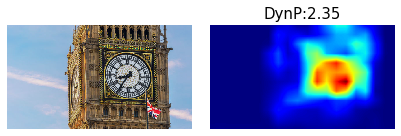

In [4]:
def main():
#     args = parser.parse_args()


    # setting up the visible GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

    print(">> Loading network:\n>>>> '{}'".format('../pre-trained/Res101_DAME.pth.tar'))
    
    # fine-tuned network from path
    state = torch.load('../pre-trained/Res101_DAME.pth.tar')

    net_params = {}
    net_params['architecture'] = state['meta']['architecture']
    net_params['pooling'] = state['meta']['pooling']
    net_params['local_whitening'] = state['meta'].get('local_whitening', False)
    net_params['regional'] = state['meta'].get('regional', False)
    net_params['whitening'] = state['meta'].get('whitening', False)
    net_params['mean'] = state['meta']['mean']
    net_params['std'] = state['meta']['std']
    net_params['pretrained'] = False


    net = TYY_init_network(net_params)
    
    net.load_state_dict(state['state_dict'])
    

    # moving network to gpu and eval mode
    net.cuda()
    net.eval()

    # set up the transform
    normalize = transforms.Normalize(
        mean=net.meta['mean'],
        std=net.meta['std']
    )
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])


    Lw = torch.load('../whitening/WEB_retrieval-SfM-120k.pth')

    ms = [1, 1/2**(1/2), 1/2]
    msp = 3
    
    with torch.no_grad():
    
        print('========== Custom input ==========')
        input = Image.open('../images/big_ban.jpg')
        input = transform(input).unsqueeze(0)
        input = input.cuda()
        # input = input[:,:,0:int(1024/3*2),:]
        

        vecs0, DynP_v_ms = DynP_extract_ms(net, input, ms, msp)
        
        vecs0 = vecs0.unsqueeze(-1).cpu().numpy()
        
        print('----- Whitening ensemble binarization -----')
        
        dim = 2048
        
        vecs_lw1  = whitenapply(vecs0, Lw['m'], Lw['P'],dimensions=dim) # projection matrix P with 100% samples
        
        vecs_lw2  = whitenapply(vecs0, Lw['m'], Lw['P_90'],dimensions=dim) # projection matrix P with top 90% samples
        
        vecs_lw3  = whitenapply(vecs0, Lw['m'], Lw['P_80'],dimensions=dim) # projection matrix P with top 80% samples
        
        vecs_lw4  = whitenapply(vecs0, Lw['m'], Lw['P_50'],dimensions=dim) # projection matrix P with top 50% samples
        

        print('----- Binary codes -----')
        def b_fn(v):
            med = np.median(v,axis=0,keepdims=True)
            bv = np.less(v,med)
            return bv.astype(float)*2-1

        vecs_lw_2x = np.concatenate([b_fn(vecs_lw1),b_fn(vecs_lw2)],axis=0)
        print('Binary global descriptor (2x)')
        print('==> Optimal storage size: '+str(vecs_lw_2x.shape[0]/8/1024)+'KB')

        vecs_lw_4x = np.concatenate([b_fn(vecs_lw1),b_fn(vecs_lw2),b_fn(vecs_lw3),b_fn(vecs_lw4)],axis=0)
        print('Binary global descriptor (4x)')
        print('==> Optimal storage size: '+str(vecs_lw_4x.shape[0]/8/1024)+'KB')


        print('========== Attention of DAME ==========')

        v_temp = net.features(input)
        _, dyn_p = net.DAME3(v_temp)

        attn = torch.pow(v_temp.clamp(min=1e-6),dyn_p)
        attn = torch.sum(attn,1,keepdim=True)
        attn = F.interpolate(attn, 
                    size=(input.shape[2], input.shape[3]), mode='bilinear',align_corners=True).squeeze().cpu().numpy()
        attn = (attn - np.min(attn)) / (np.max(attn) - np.min(attn))
        
        output = np.transpose(input.squeeze().cpu().numpy(),(1,2,0))
        output = (output - np.min(output)) / (np.max(output) - np.min(output))
        
        fig = plt.figure()
        plt.subplot(121)
        plt.tight_layout()
        plt.imshow(output)
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(attn,cmap=plt.cm.jet)
        plt.axis('off')
        plt.title('DynP:%.2f'%(dyn_p.cpu().numpy()),fontsize=15)
        plt.show()

if __name__ == '__main__':
    main()